In [ ]:
from imports import *  
from tools import *

/Users/abarnes/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'

table = QTable.read('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue_wassociations_wprops_fixediso_10pc.fits' %root_dir)
# table_wasso = QTable.read('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue_wassociations_fixediso_10pc.fits' %root_dir)
# table_wprops = QTable.read('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue_wassociations_wprops_fixediso_10pc.fits' %root_dir)

table.colnames

['gal_name',
 'region_ID',
 'x_max',
 'y_max',
 'x_com',
 'y_com',
 'ra_max',
 'dec_max',
 'ra_com',
 'dec_com',
 'npix',
 'HA6562_FLUX_HST',
 'HA6562_FLUX_ERR_HST',
 'area_exact',
 'radius_circ',
 'flux_max',
 'flux_min',
 'flux_mean',
 'radius_circ_pc',
 'x_mom',
 'y_mom',
 'ra_mom',
 'dec_mom',
 'area_ellipse',
 'major_sigma',
 'minor_sigma',
 'mean_sigma',
 'position_angle',
 'mean_sigma_pc',
 'complexity_score',
 'complexity_score_leaves',
 'complexity_rms',
 'complexity_std',
 'flag_edge_hst',
 'EW_HA6562_raw_MUSE',
 'EW_HA6562_raw_ERR_MUSE',
 'EW_HB4861_raw_MUSE',
 'EW_HB4861_raw_ERR_MUSE',
 'EW_HA6562_fit_MUSE',
 'EW_HA6562_fit_ERR_MUSE',
 'EW_HB4861_fit_MUSE',
 'EW_HB4861_fit_ERR_MUSE',
 'EW_HA6562_bgcorr_MUSE',
 'EW_HA6562_bgcorr_ERR_MUSE',
 'EW_HB4861_bgcorr_MUSE',
 'EW_HB4861_bgcorr_ERR_MUSE',
 'HA6562_FLUX_CORR_HST',
 'HA6562_FLUX_ERR_CORR_HST',
 'HA6562_LUMINOSITY_HST',
 'HA6562_LUMINOSITY_ERR_HST',
 'region_circ_rad_pc_MUSE',
 'flag_touch_hst',
 'region_ID_association_v_

# GET BOLO LUMINOSITY

In [11]:
"""Get SB99 models"""
inputdir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/sb99/fiducial/fiducial_6p0linear' 

names_quanta = ['TIME', 'QHI', 'QHIf', 'QHeI', 'QHeIf', 'QHeII', 'QHeIIf', 'logL']
names_power = ['TIME', 'ALLp', 'OBp', 'RSGp', 'LBVp', 'WRp', 'ALLe', 'ALLm', 'OBm', 'RSGm', 'LBVm', 'WRm']
names_yield  = ['TIME', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Mdotwind', 'Mdotsne','Mdotboth', 'Mtot']


t_ewidth = QTable.read('%s/fiducial_6p0linear.ewidth1' %(inputdir), format='ascii', header_start=3, data_start=4)
t_quanta = QTable.read('%s/fiducial_6p0linear.quanta1' %(inputdir), format='ascii', data_start=5, names=names_quanta)
t_power = QTable.read('%s/fiducial_6p0linear.power1' %(inputdir), format='ascii', data_start=5, names=names_power)
t_yield = QTable.read('%s/fiducial_6p0linear.yield1' %(inputdir), format='ascii', data_start=5, names=names_yield)

tmax = 10 *u.Myr
tmin = 0 *u.Myr
time = t_ewidth['TIME']
time.unit = u.yr
time = time.to('Myr')
mask = ((time>tmin) & (time<tmax))
time = time[mask]
Q = t_quanta['QHI'][mask]
Mdot = t_yield['Mdotwind'][mask]
Lmech = t_power['ALLp'][mask]
Lbol = t_quanta['logL'][mask]
LHa = t_ewidth['LUM(H_A)'][mask]
Lfrac_array = 10**(t_quanta['logL'][mask]-t_ewidth['LUM(H_A)'][mask])

age = table['age_association_nuv_32pc']
age.unit = u.Myr 

# Determine the Lbol/LHa ratio for the HST regions...
Lfrac = np.empty(len(age)) *np.nan 
for i in range(len(age)):
    _, id_ = find_nearest(time.value, age.value[i])
    if id_==0:
        continue
    Lfrac[i] = Lfrac_array[id_]
    
table['Lbol/LHa'] = Lfrac *u.dimensionless_unscaled

In [12]:
def get_Lbol(Lha, conv=138):
    return conv*Lha

KE12_conv = 138 # with constant Kennicutt & Evans (2012) - also Lopez et al. (2014)
B21_conv = 88.2 # with constant conversion from Barnes21
low_conv = 17.684 # with lower limit from ionising photons only

Lbol      = get_Lbol(table['HA6562_LUMINOSITY_HST'], conv=table['Lbol/LHa'])
Lbol_KE12 = get_Lbol(table['HA6562_LUMINOSITY_HST'], conv=KE12_conv) 
Lbol_B21  = get_Lbol(table['HA6562_LUMINOSITY_HST'], conv=B21_conv)
Lbol_low  = get_Lbol(table['HA6562_LUMINOSITY_HST'], conv=low_conv) 

table['Lbol'] = Lbol
table['Lbol_KE12'] = Lbol_KE12
table['Lbol_B21'] = Lbol_B21
table['Lbol_low'] = Lbol_low

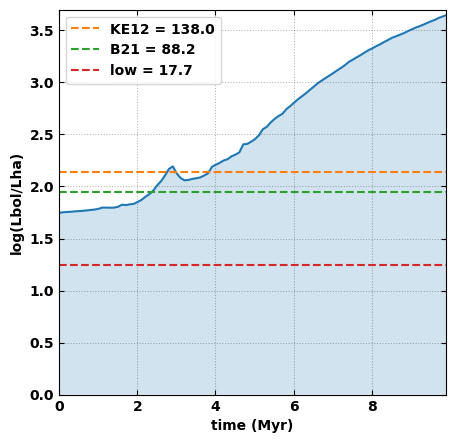

In [13]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()

ax.plot(time, np.log10(Lfrac_array))
ax.fill_between(time.value, np.log10(Lfrac_array.value), alpha=0.2)


ax.plot([0,10], np.log10([KE12_conv, KE12_conv]), label='KE12 = %0.1f' %KE12_conv, ls='--')
ax.plot([0,10], np.log10([B21_conv, B21_conv]), label='B21 = %0.1f' %B21_conv, ls='--')
ax.plot([0,10], np.log10([low_conv, low_conv]), label='low = %0.1f' %low_conv, ls='--')

ax.set_xlim([0,9.9])
ax.set_ylim([0,3.7])
ax.set_xlabel('time (Myr)')
ax.set_ylabel('log(Lbol/Lha)')
ax.legend()

ax.grid(alpha=0.3, linestyle=':')

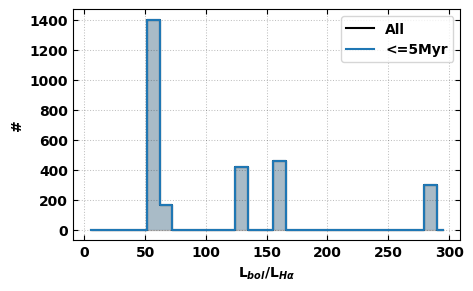

In [14]:
Lfrac_masked = Lfrac[age<=5*u.Myr]

bins = np.linspace(0, 300, 30)
bins1, bins_cent1, hist1 = get_hist(Lfrac, bins=bins, norm=False)
bins2, bins_cent2, hist2 = get_hist(Lfrac_masked, bins=bins, norm=False)

fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)
ax.plot(bins_cent1, hist1, ds='steps-mid', c='black', label='All')
ax.plot(bins_cent2, hist2, ds='steps-mid', label='<=5Myr')

ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid', color='black')
ax.fill_between(bins_cent2, hist2, alpha=0.2, step='mid')

ax.set_xlabel("L$_{bol}$/L$_{H\\alpha}$")
ax.set_ylabel("#")
ax.legend()

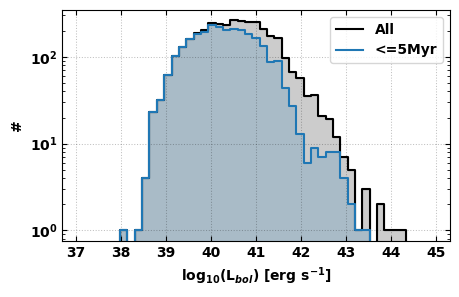

In [15]:
Lbol_masked = Lbol[age<=5*u.Myr]

bins = np.linspace(37,45,50)
bins1, bins_cent1, hist1 = get_hist(np.log10(Lbol.value), bins=bins, norm=False)
bins2, bins_cent2, hist2 = get_hist(np.log10(Lbol_masked.value), bins=bins, norm=False)

fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)
ax.plot(bins_cent1, hist1, ds='steps-mid', c='black', label='All')
ax.plot(bins_cent2, hist2, ds='steps-mid', label='<=5Myr')

ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid', color='black')
ax.fill_between(bins_cent2, hist2, alpha=0.2, step='mid')

ax.set_yscale('log')

ax.set_xlabel("log$_{10}$(L$_{bol}$) [erg s$^{-1}$]")
ax.set_ylabel("#")
ax.legend()

# GET PRESSURES

## Pdir + Ptherm

In [18]:
def get_Pdir(Lbol, r):
    """Taken from Lopez et al. (2014)"""
    Pdir = (3/(4*np.pi)) * (Lbol/(r**2*const.c)) 
    Pdir = Pdir/const.k_B
    return Pdir.to('K/cm^3')

def get_Ptherm(ne, temp, ionisation=2):
    """ionisation=2 assumes single ionised He"""
    Ptherm = const.k_B*ne*temp*ionisation
    Ptherm = Ptherm/const.k_B
    return Ptherm.to('K/cm^3')

In [19]:
radius_circ_pc  = table['radius_circ_pc']
radius_mom_pc   = table['mean_sigma_pc']
radius_strom_pc = table['radius_strom_pc']

Pdir_circ  = get_Pdir(Lbol, radius_circ_pc)
Pdir_mom   = get_Pdir(Lbol, radius_mom_pc)
Pdir_strom = get_Pdir(Lbol, radius_strom_pc)

Pdir_circ_Lbol_B21  = get_Pdir(Lbol_B21, radius_circ_pc)
Pdir_mom_Lbol_B21   = get_Pdir(Lbol_B21, radius_mom_pc)
Pdir_circ_Lbol_KE12  = get_Pdir(Lbol_KE12, radius_circ_pc)
Pdir_mom_Lbol_KE12   = get_Pdir(Lbol_KE12, radius_mom_pc)

table['Pdir_circ']  = Pdir_circ
table['Pdir_mom']   = Pdir_mom
table['Pdir_strom'] = Pdir_strom

table['Pdir_circ_Lbol_B21']  = Pdir_circ_Lbol_B21
table['Pdir_mom_Lbol_B21']   = Pdir_mom_Lbol_B21
table['Pdir_circ_Lbol_KE12']  = Pdir_circ_Lbol_KE12
table['Pdir_mom_Lbol_KE12']   = Pdir_mom_Lbol_KE12

In [24]:
ne = table['ne']
t_n2 = table['TEM_NII_MUSE']

Ptherm = get_Ptherm(ne, t_n2)
table['Ptherm'] = Ptherm

In [25]:
table.write('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue_wassociations_wprops_wpressures_fixediso_10pc.fits' %root_dir, overwrite=True)

## Pwind

In [54]:
# TODO